# Exercise 1 for the class EE-568 Theory and Methods of Reinforcement Learning taught at EPFL in Spring 2024 by Prof. Volkan Cevher

In [2]:
import os
from typing import List

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys

sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from plot import plot_log_lines, plot_lines
%load_ext autoreload
%autoreload 2

# Dynamic Programming exercise

We will make use of the operators introduced in the slides of lectures 1 and 2. 
$(T V)(s)$, $\mathcal{G}$ and $T^{\pi}$

Before diving into the implementation of Value Iteration or Policy Iteration, we instantiate an environment using the library in the foilder `src`.

The gridworld environment is instantiated via the class `GridWorldEnvironment`. It takes 4 input values:

- `reward_mode` : integer between 0 and 3 for different reward profiles
- `size`: Gridworld size
- `prop`: probability assigned to the event that the agent do not follow the chosen action but another one selected uniformely at random.
- `gamma`: the discount factor of the environment.

In [3]:
reward_mode = 2 # put an image to show which is the reward
size = 10 
prop = 0
gamma=0.99 # rename discount_factor
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)

Below, we illustrate how to access the gridworld environment, i.e. how to access the reward, the transition matrix and the discount factor.

In [4]:
size = 3
gridworld_example = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)


***Interface with a Gridworld instance***
- `print(gridworld.n_states)` #return the number of states
- `print(gridworld.n_actions)` #return the number of actions
- `print(gridworld.r)` #return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` #Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.



<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

Then we set up the solver object that will implement the routine needed to evaluate the value of the produced policies

In [5]:
solver = MDPsolver(gridworld)

We will use this solver to compute the optimal value function to measure the suboptimality of the policies produced by value iteration or policy iteration.

To access the optimal value function use `solver.v`.

In [6]:
solver.value_iteration()

## Ex 1: Value Iteration [25 pts.]

### 1.1 Implement value iteration

In [7]:
def value_iteration(env, tol=1e-10):
    """Inplementation of value iteration, note that the implementation is based on value iteration mentioned in the lecture.
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        policies: policy  at each iteration (list)
        vs: value functions at each iteration (list)
    """
    policies = []
    vs = []
    v = np.zeros(env.n_states) # initialize value function
    q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
    
    while True:
        v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
        for a in range(env.n_actions):
            # 1 for each function, we need to calculate the Q-value: Q(s,a) = r(s,a) + gamma * sum_s' P(s'|s,a) * V(s')
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)# calculate Q-value
        # 2 update value function: V(s) = max_a Q(s,a)    
        v = np.max(q, axis=1)# update value function
        # 3 extract greedy policy: pi(s) = argmax_a Q(s,a)
        policy = np.argmax(q, axis=1)
        policies.append(policy) # obtain policy
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol: # convergence criterion
            break
    return policies, vs

In [8]:
policies, vs = value_iteration(gridworld)

### 1.2: Evaluate the extracted policies

For the evaluation of the sequence of policies, i.e. computing $V^\pi$ for each policy $\pi$ we recall that $V^\pi$ is the fixed point $V^\pi = T^\pi (V^\pi)$.
In the following code, we ask you to apply the operator $T^\pi$ a number of time sufficient to find a value $V$ such that $ || T^\pi(V) - V || \leq \mathrm{tol}$

In [9]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    """Inplementation of policy evaluation through iteratively applying policy value iteration 
    Args:
        policies: a list of policies obtained by section 1.1
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        values: a list of value function for each policy
    """
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v) #calculate Q-value
            for s in range(env.n_states):
                action_taken = pi[s] # obtain the action determined by the policy
                v[s] = q[s, action_taken] #calculate value function by $v(s) = Q(s,pi(s))$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [10]:
values = evaluate_policy_sequence(policies, gridworld)

### 1.3: Plot the results 

Plot using the method ```plot_lines(list_to_plot, list_name, axis_label, folder, title, x_axis = None, show = False) ```

Compute both the iterates $V_t$ produced by value iteration and the value function achieved by the extracted policies $V^{\pi_t}$ with $\pi_t = \mathcal{G}(V_t)$. What do you observe ?


***Answer:***

When computing the iterates $V_t$ from value iteration and the value functions $V^{\pi_t}$ of the greedy policies (i.e., $\pi_t = \mathcal{G}(V_t)$), I observe that:

- Upper bound behavior:  
  The sequence $\{V_t\}$ typically lies above the sequence $\{V^{\pi_t}\}$. This is because the Bellman update in value iteration takes a per-state maximization that can overestimate the value obtainable by any single consistent policy. In other words, while  

  $$
  V_t(s) = \max_a \Bigl[ r(s,a) + \gamma \sum_{s'} P(s'\mid s,a) \, V_{t-1}(s') \Bigr],
  $$

  the value $V^{\pi_t}(s)$, which is the value of following the greedy policy derived from $V_t$, is generally lower.

- Convergence to optimality:  
  Despite the initial gap, both $\{V_t\}$ and $\{V^{\pi_t}\}$ converge to the same optimal value function $V^\star$ as $t$ increases. The contraction property of the Bellman operator ensures that the overestimation in $V_t$ is gradually corrected, and eventually the gap between $V_t$ and $V^{\pi_t}$ closes.

- Log scale visualization:  
  The use of a logarithmic scale in the plot makes it easier to observe the differences in suboptimality across iterations. The early iterations show a significant gap between $V_t$ and $V^{\pi_t}$, which is clearly visible due to the log scale. Additionally, the sharp drops in suboptimality for $V^{\pi_t}$ are highlighted more effectively.

In summary, during the iterative process, $V_t$ serves as an upper bound for $V^{\pi_t}$, but both sequences converge to $V^\star$.

In [11]:
def compute_subopt(values, v_star):
    """
    Args:
        values: a list of value function.
        v_star: the optimal value function obtained by MDP.solver
    Returns:
        subopts: an array indicates the suboptimality.
    """
    subopts = []
    for v in values:
        i = np.argmax(np.abs(v - v_star))
        subopts.append(-v[i] + v_star[i])
    return np.array(subopts)

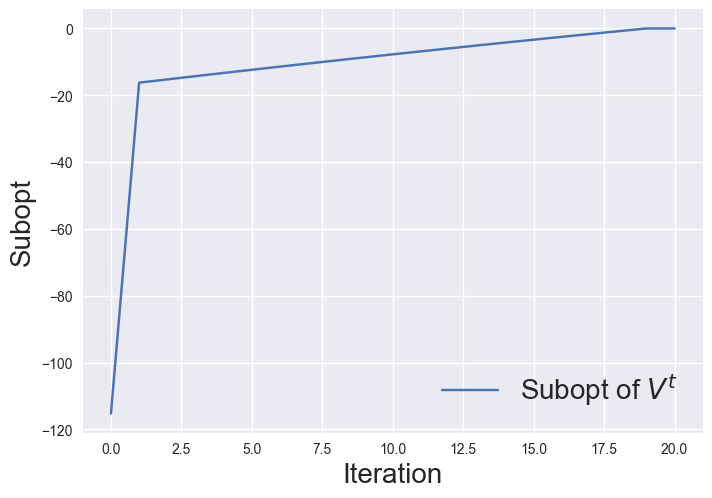

In [12]:
plot_lines([compute_subopt(vs, solver.v)], [r"Subopt of $V^t$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

**Question** : 
- Prove that $T$ is a contraction, that is $|| T(V) - T(V') ||_{\infty} \leq \gamma || V - V' ||_{\infty}$.
- Why the iterates of Value Iterations are an upper bound to $V^\star$ ? How is this possible considering that $V^\star \triangleq \max_{\pi \in \Pi} V^{\pi}$ ?

***Answers***

1. Let $T$ be the Bellman optimality operator:
$$
(TV)(s) = \max_a \Bigl[ r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) \, V(s') \Bigr].
$$

For any two value functions $V$ and $V'$, we have:
$$
|(TV)(s) - (TV')(s)| \le \gamma\,\max_a \Bigl|\sum_{s'} P(s' \mid s,a)\bigl(V(s') - V'(s')\bigr)\Bigr| \le \gamma\,\|V - V'\|_\infty.
$$

Taking the maximum over all states yields:
$$
\|TV - TV'\|_\infty \le \gamma\,\|V - V'\|_\infty.
$$

Thus, $T$ is a $\gamma$-contraction under the $\|\cdot\|_\infty$ norm.

2. Value Iteration updates the value function as follows:
$$
V_{t+1}(s) = \max_a \Bigl[ r(s,a) + \gamma \sum_{s'} P(s' \mid s,a) \, V_t(s') \Bigr].
$$

At each state, this update takes the maximum over actions, effectively choosing the best one-step lookahead value. However, this maximization is performed independently for each state, which does not necessarily correspond to a single consistent policy. As a consequence, the intermediate iterates $V_t$ can be higher than $V^\star$, where
$$
V^\star = \max_{\pi \in \Pi} V^\pi,
$$
because no single policy can simultaneously achieve these locally optimal actions in every state. The overestimation is corrected by the contraction property of $T$, ensuring that $V_t$ converges to $V^\star$ as $t$ increases.

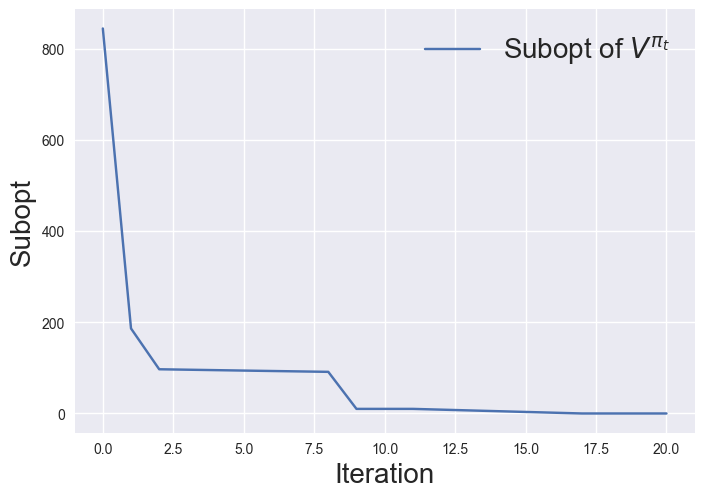

In [13]:
plot_lines([compute_subopt(values, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

To better appreciate the difference in the convergence plot use log scale.

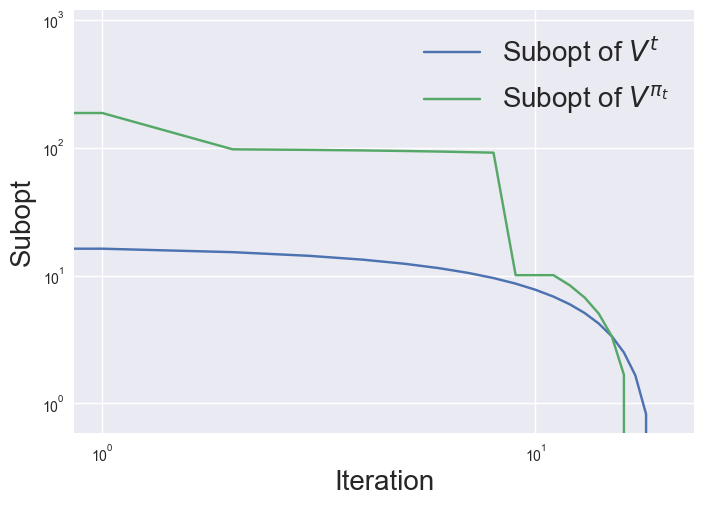

In [14]:
plot_log_lines([-compute_subopt(vs, solver.v), compute_subopt(values, solver.v)], 
               [r"Subopt of $V^t$", "Subopt of $V^{\pi_t}$"], 
               ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

# Ex 2: Policy Iteration [25 pts.]

In [15]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [16]:
def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = []
    for s in range(q.shape[0]):
        policy.append(np.argmax(q[s, :]))
    return policy

In [17]:
def policy_iteration(env, tol=1e-20):
    """Implementation of policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env, tol=1e-10)
        pi = get_greedy_policy(q)
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs, pi

In [18]:
values_pi, final_pi = policy_iteration(gridworld)

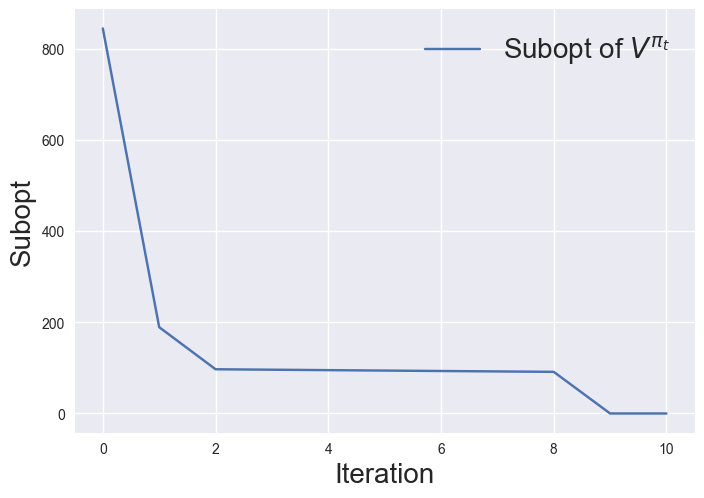

In [19]:
plot_lines([compute_subopt(values_pi, solver.v)], ["Subopt of $V^{\pi_t}$"], ["Iteration", "Subopt"], "figs", "VI.pdf", show = True)

### Compare with Value Iteration

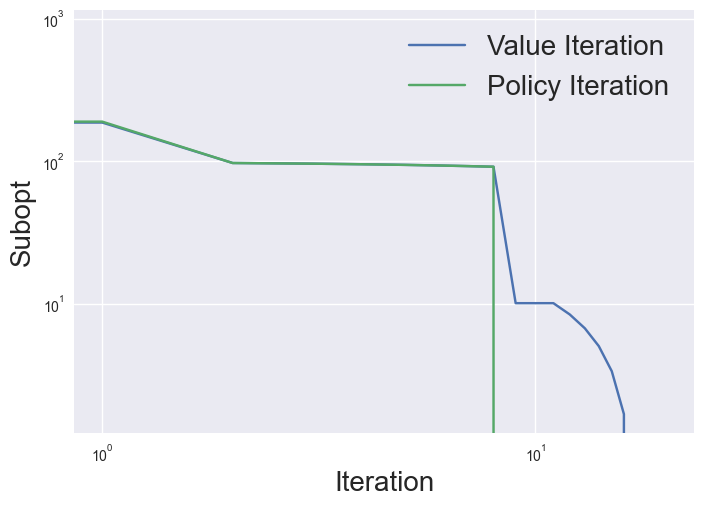

In [20]:
plot_log_lines([compute_subopt(values, solver.v), compute_subopt(values_pi, solver.v)], 
               ["Value Iteration", "Policy Iteration"], 
               ["Iteration", "Subopt"], "figs", "VIvsPI.pdf", show = True)

***Questions :*** 
- Which algorithm converges faster ?
- Is it theoretically expected ? Answer listing the expected number of iterations needed for VI and PI to converge ?


***Answers***

1. From the plots, Policy Iteration converges in fewer iterations than Value Iteration. In practice, Policy Iteration often converges in fewer iterations because each policy update jump-starts the value function closer to the optimal solution.

2.  Yes. For a discount factor $\gamma < 1$,  
   - Value Iteration typically needs $\mathcal{O}\bigl(\frac{1}{1-\gamma}\log\frac{1}{\varepsilon}\bigr)$ iterations to reach an $\varepsilon$-accurate solution.  
   - Policy Iteration can converge in at most a finite number of policy improvements (often far fewer in practice), so it generally requires fewer iterations than Value Iteration (though each iteration can be more computationally expensive).

***Theory Questions*** 
- Prove the policy improvement theorem.
- Prove that the Bellman operator is monotone elementwise. That is if $V > V'$, then for any $\pi$, $T_{\pi}(V) > T_{\pi}(V')$.

***Answers***

1. Let $\pi$ be any policy, and define a new policy $\pi'$ by  
   $$
   \pi'(s) \;=\; \arg\max_{a}\;Q^{\pi}(s,a),
   $$  
   where $Q^\pi(s,a)$ is the action-value function for policy $\pi$. Then for every state $s$,  
   $$
   Q^\pi\bigl(s,\pi'(s)\bigr) \;\ge\; Q^\pi\bigl(s,\pi(s)\bigr) \;=\; V^\pi(s).
   $$
   By standard MDP arguments, this implies $V^{\pi'}(s) \;\ge\; V^\pi(s)$ for all $s$, i.e. the new policy $\pi'$ is at least as good as $\pi$.  

2. Let $T_\pi$ be the Bellman operator for a fixed policy $\pi$. Suppose $V \ge V'$ elementwise. Then  
   $$
   T_\pi(V)(s) 
   \;=\; r_\pi(s) \;+\;\gamma\sum_{s'}P_\pi(s'|s)\,V(s')
   \;\ge\; 
   r_\pi(s) \;+\;\gamma\sum_{s'}P_\pi(s'|s)\,V'(s')
   \;=\;
   T_\pi(V')(s).
   $$
   Thus, $V \ge V' \;\Longrightarrow\; T_\pi(V) \ge T_\pi(V')$, which shows $T_\pi$ is monotone.

# Ex 3: Modified Policy Iteration [25 pts.]

In this cell you will code and run Modified Value Iteration, that follows this pseudocode:
- $\pi_{k+1} = \mathcal{G}(V_k)$
- $V_{k+1} = T^m_{\pi_{k+1}}(V_k)$

In the implementation, we will use also the variable $Q$ as in the previous implementation of VI and PI for convenience of implementation.

**Questions**

Which value of $m$ recovers policy iteration ?
Which value of $m$ recovers value iteration ?

***Answers***

- Policy Iteration is recovered when $m \to \infty$ (i.e., when full policy evaluation is performed at each iteration).
- Value Iteration is recovered when $m = 1$ (i.e., when only one Bellman update is applied per iteration).

First, write a function that applies the Bellman evaluation operator $m$ times

In [21]:
def policy_operator_m_times(pi, m, env, v, q):
    """Implementation of partial policy evaluation through applying m times the Bellman operator
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
        v: initial value vector
        q: initial state action value vector
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    i = 0
    while i < m:
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s, pi[s]]
        i = i + 1
    return v, q

At this point, using the function `get_greedy_policy` implemented for PI you are ready to implement Modified Policy Iteration !

In [22]:
def modified_policy_iteration(env, m, tol=1e-10):
    """Implementation of modified policy iteration
    Args:
        env: environment
        tol: a scalar to dermerminate whether the algorithm convergences
    Returns:
        vs: value functions at each iteration (list)
    """
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.zeros(env.n_states, dtype=int)
    while True:
        v_old = np.copy(v)
        pi = get_greedy_policy(q)
        v, q = policy_operator_m_times(pi, m, env, v, q)
        policies.append(pi.copy())
        vs.append(v)
        if np.linalg.norm(v - v_old) < tol:
            break
    return vs,policies

Now run modified policy iteration for different values of $m$ for example between $1$ and $10$. 

In [23]:
m_values = ["1", "2", "3", "5", "10", "20"]
to_plot = []
for m in m_values:
    m = int(m)
    _, policies_mpi=modified_policy_iteration(gridworld, m)
    values_mpi = evaluate_policy_sequence(policies_mpi, gridworld)
    to_plot.append(compute_subopt(values_mpi, solver.v))

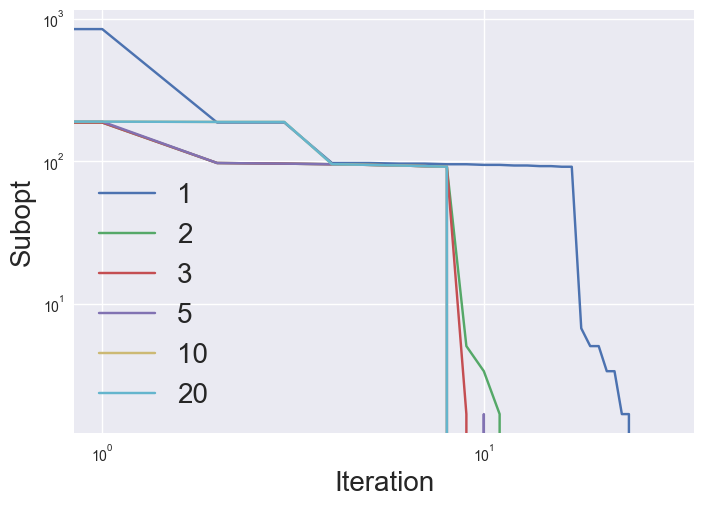

In [24]:
plot_log_lines(to_plot, 
           m_values, 
           ["Iteration", "Subopt"], "figs", "MPI.pdf", show = True)

**Questions** 
- How does the value of $m$ affect convergence ?
- Which is the cost per iteration of Modified Policy Iteration ?
- Which is the cost per iteration of Policy Iteration implemented with Option 2 in the slides ?

***Answers***

**Answer**:

1. As $m$ increases, each policy evaluation step is more complete, so the convergence in terms of iteration count tends to be faster. However, each iteration is more computationally expensive because it performs $m$ Bellman updates.

2. Each iteration requires:
   - A partial policy evaluation of $m$ steps (each step does a pass over all states),
   - A greedy policy improvement step.

   So, the cost is roughly $\mathcal{O}(m \times |\mathcal{S}|)$ per iteration (plus the cost of policy improvement).

3. Under option 2, policy evaluation is done by directly solving the linear system:

   $$
   V^\pi = \bigl(I - \gamma P^\pi\bigr)^{-1} R^\pi.
   $$

   This involves inverting an $\lvert\mathcal{S}\rvert \times \lvert\mathcal{S}\rvert$ matrix (or equivalently solving a system of linear equations). The naive cost of such an inversion is $\mathcal{O}(\lvert\mathcal{S}\rvert^3)$ per iteration. After this exact evaluation, a single greedy policy improvement step is performed.

# Ex 4: Q-Learning [15 pts.]

Now, we are ready to tackle the problem in the model free setting. For technical reason, we focus on the finite horizon setting in this part and we compare two exploration strategies.
1. **$\varepsilon$-greedy** (Watkins, Christopher John Cornish Hellaby. “Learning from Delayed Rewards.” PhD Thesis, King’s College, Cambridge United Kingdom, 1989.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Sample $b_h \sim \text{Bernoulli}(\varepsilon), \hat{a}_h \sim \text{Uniform}(\mathcal{A})$
      - Take action $a_h \leftarrow \left[(1-b_h) \left(\underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}\right) + b_h \hat{a}_h \right]$ and observe $x_{h+1}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha)Q_h(x_h,a_h) +\alpha\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1})\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$
2. **UCB bonuses** (Jin, Chi, Zeyuan Allen-Zhu, Sebastien Bubeck, and Michael I Jordan. “Is Q-Learning Provably Efficient?” In Advances in Neural Information Processing Systems, Vol. 31. Curran Associates, Inc., 2018. https://proceedings.neurips.cc/paper/2018/hash/d3b1fb02964aa64e257f9f26a31f72cf-Abstract.html.)
  - Initialize $V_h(x) \leftarrow H, Q_h(x,a) \leftarrow H$ and $N_h(x,a) \leftarrow 0$ for all $(x,a,h)\in \mathcal{S} \times \mathcal{A} \times [H], V_{H}(x) \leftarrow 0$ for all $x \in \mathcal{S}$  
  - For episode $k=1,\dots,K$ do
    - Receive $x_1$
    - For step $h=1,\dots,H$ do
      - Take action $a_h \leftarrow \underset{a' \in \mathcal{A}}{\text{argmax}}{Q_h(x_h,a')}$ and observe $x_{h+1}$
      - $t=N_h(x_h,a_h)\leftarrow N_h(x_h,a_h) + 1, \alpha_t = \frac{H+1}{H+t}$ and $b_t \leftarrow c\sqrt{\frac{H^3}{t}}$
      - $Q_h(x_h,a_h)\leftarrow (1-\alpha_t)Q_h(x_h,a_h) +\alpha_t\left[r_h(x_h,a_h) + V_{h+1}(x_{h+1}) + b_t\right]$
      - $V_h(x_h)\leftarrow \min{\left\{H, \underset{a' \in \mathcal{A}}{\max}{Q_h(x_h,a')}\right\}}$

For other technical reason, we also need to rescale the reward between 0 and 1, as done in the following

In [25]:
reward_mode = 0
size = 10
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

### Q learning with epsilon greedy 

In this subsection, we implement $Q$ Learning with the simplest possible exploration strategy: $\epsilon$-greedy.

In [26]:
def argmax_with_random_tie_breaking(b):
    return np.random.choice(np.where(b == b.max())[0])

In [27]:
def q_learning_epsilon_greedy(K: int = 100000, H: int = 20, epsilon: float = 0.1, alpha: float = 0.1) -> List[float]:
    """
    Function implementing the epsilon-greedy Q-learning algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param epsilon: Algorithm hyperparameter, exploration probability, float in [0, 1]
    :param alpha: Algorithm hyperparameter, Q update weight, float in [0, 1]

    :return: reward after each step, list of K * H floats
    """
    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            explore = np.random.binomial(2, p=epsilon)
            if explore:
                # Exploration: With probability epsilon take a random action
                a = np.random.choice(gridworld.n_actions)
            else:
                # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
                a = argmax_with_random_tie_breaking(Q[h, state, :])

            # Get reward for action
            rewards.append(gridworld.r[state, a])

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Update Q according to the algorithm
            Q[h, state, a] = (1 - alpha) * Q[h, state, a] + alpha * (
                gridworld.r[state, a] + V[h + 1, new_state]
            )

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.min([np.max(Q[h, state, :]), H])

            state = new_state
    return rewards

In [28]:
reward_eps_greedy = q_learning_epsilon_greedy()  # You can play around with the arguments if you like
cumulative_reward_eps_greedy = np.cumsum(reward_eps_greedy)

### Q-Learning with bonuses

In this subsection, you are asked to implement an optimistic version of  Q Learning suggested in (Jin et al., 2018)

In [29]:
def q_learning_ucb_bonuses(K: int = 100000, H: int = 20, c: float = 0.0001) -> List[float]:
    """
    Function implementing the Q-learning with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param c: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    V[H, :] = 0
    N = np.ones((H, gridworld.n_states, gridworld.n_actions))

    for k in range(K):  # Episode loop
        state = 99  # Initial state
        for h in range(H):  # Step loop
            # Take one of the optimal actions for the current state
            a = argmax_with_random_tie_breaking(Q[h, state, :])
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])

            # Calculate the UCB bonus
            bonus = c * np.sqrt(H ** 3 / N[h, state, a])

            # Calculate the adaptive alpha according to the algorithm
            alpha = (H + 1) / (H + N[h, state, a])

            # Update Q according to the algorithm
            Q[h, state, a] = (1 - alpha) * Q[h, state, a] + alpha * (
                gridworld.r[state, a] + V[h + 1, new_state] + bonus
            )

            # Update V as the Q-value of the optimal actions for the current state
            V[h, state] = np.max(Q[h, state, :])
            V[h, state] = np.clip(V[h, state], 0, H)

            state = new_state

    return rewards

In [30]:
reward_UCB = q_learning_ucb_bonuses()  # You can play around with the arguments if you like
cumulative_reward_UCB = np.cumsum(reward_UCB)

### Comparison of exploration strategies

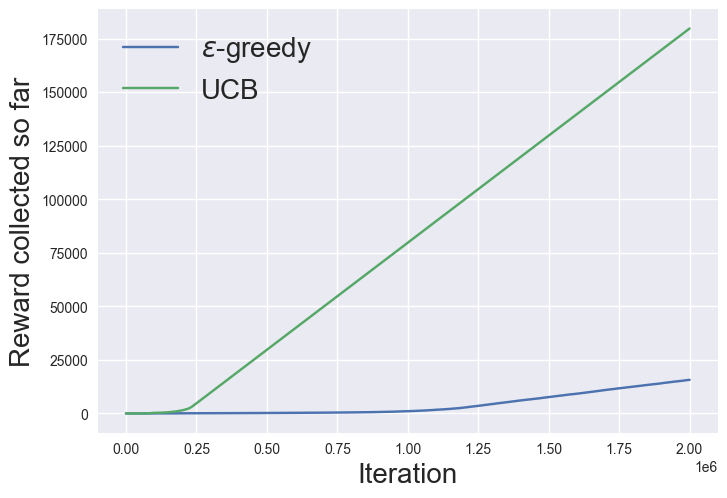

In [32]:
plot_lines(
    [cumulative_reward_eps_greedy, cumulative_reward_UCB],
    [r"$\epsilon$-greedy", "UCB"],
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=True
)

**Question:** You are given an environment with $N$ states linked in a chain, i.e. from every state except the two endpoints there are two possible actions going right or go back to the first state in the chain. For the endpoints the second action is to stay in the same state. The reward is only 1 if you are in the rightmost state and stay there, otherwise 0. What is the probability that the $\varepsilon$-greedy algorithm will have a positive reward after $H$ steps in the first episode, if the chosen initial state is the leftmost state in the chain?


1. In the described chain, we must reach the rightmost state (say state $N$) from the leftmost state (say state $1$) and then select the “stay” action in state $N$ to receive a reward of 1. For the first episode, all $Q$-values are equal, so $\varepsilon$-greedy acts essentially like random uniform selection among the available actions.

   - To move from state 1 to state $N$ using the “go right” action (repeatedly) requires $(N-1)$ consecutive picks of “go right.”
   - Once at state $N$, we must pick “stay” to get the reward.

   If each step has a $1/2$ chance of choosing the “correct” action (when $Q$-values are all the same), the probability of this exact sequence (move right $(N-1)$ times, then stay) is $(1/2)^{N}$. If the horizon $H < N$, this probability is 0 because we cannot reach and stay in the rightmost state in fewer than $N$ steps.

**Question:** Does the empirical result match the theoretical result described in (Jin et al. 2018) ? Try to answer this question after reading their Appendix A and looking at their Table 1 for the algorithm they call UCB-H.

Yes. Their analysis shows that an optimistic or bonus-based approach can explore more efficiently, leading to polynomial sample complexity in $N$ and $H$. By contrast, $\varepsilon$-greedy may need exponentially many samples (episodes) to discover the rewarding rightmost state with high probability. The plots typically show that UCB-based methods accumulate reward much faster, consistent with the theoretical guarantees.

## Monte Carlo (MC) and Time Differences (TD) ( * Question ) [25 points]

Disclaimer: The TA can not help you on this part of the notebook.

In [33]:
from tqdm import tqdm
def generate_episode(policy: List, H: int, initial_state: int):
    """
    Generate an episode using the given policy.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param H: Maximum number of steps in the episode.
    :param initial_state: Starting state.

    :return: A list of (state, action, reward) tuples.
    """
    episode = []
    state = initial_state
    for _ in range(H):
        action = policy[state]
        reward = gridworld.r[state, action]
        next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])
        episode.append((state, action, reward))
        state = next_state
    return episode

def mc_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Monte Carlo policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        episode = generate_episode(policy, H, initial_state=99)  # Generate episode
        G = 0  # Return

        # Backward pass through the episode
        for t in range(len(episode) - 1, -1, -1):
            state, _, reward = episode[t]
            G = gamma * G + reward  # Discounted return

            # Update theta using gradient descent
            phi_s = phi[state]  # Feature vector for the current state
            V_hat = np.dot(theta, phi_s)  # Current value estimate
            theta += alpha * (G - V_hat) * phi_s# Gradient descent update

    return theta


In [34]:

import numpy as np
def td_policy_evaluation_with_linear_approx(
    policy: List[np.ndarray], 
    phi: np.ndarray,
    K: int = 1000, 
    H: int = 20, 
    gamma: float = 0.99, 
    alpha: float = 0.01
) -> np.ndarray:
    """
    Temporal Difference (TD) policy evaluation with linear function approximation.

    :param policy: A list where each element is a probability distribution over actions for a state.
    :param K: Number of episodes.
    :param H: Maximum number of steps per episode.
    :param gamma: Discount factor.
    :param alpha: Learning rate for gradient descent.

    :return: The learned weight vector theta.
    """
    # Feature matrix: Each state is represented by a one-hot vector
    n_states = gridworld.n_states

    # Initialize weight vector theta
    theta = np.zeros(n_states)

    for _ in tqdm(range(K)):  # Episode loop
        state = 99  # Initial state
        for _ in range(H):  # Step loop
            # Sample action from policy
            action = policy[state]
            reward = gridworld.r[state, action]
            next_state = np.random.choice(gridworld.n_states, p=gridworld.T[action][state])

            # Compute TD target and TD error
            phi_s = phi[state]  # Feature vector for current state
            phi_s_next = phi[next_state]  # Feature vector for next state
            V_s = np.dot(theta, phi_s)  # Current value estimate
            V_s_next = np.dot(theta, phi_s_next)  # Next value estimate
            td_target = reward + gamma *  V_s_next # TD target
            td_error = td_target - V_s # TD error

            # Update theta using gradient descent
            theta += alpha * td_error * phi_s

            # Move to the next state
            state = next_state

    return theta

**Case 1:**

In [57]:


_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 1000/1000 [00:31<00:00, 31.76it/s]

8.919948611419325e-07


**Case 2:**

In [58]:
_, pi=policy_iteration(gridworld)

phi = np.eye(gridworld.n_states)  # Feature matrix (one-hot encoding)
phi[:50,:]*=0

# Run Monte Carlo policy evaluation with linear function approximation
theta_MC = mc_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)
theta_TD = td_policy_evaluation_with_linear_approx(pi,phi, K=1000, H=2000, gamma=gridworld.gamma, alpha=1)

print(np.linalg.norm(theta_MC  - theta_TD))

100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]

190.43020836185028


**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 1?
- Explain your answer writing down the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case. To give this answer you can assume that $\rho$ is positive everywhere.

**Answers**


1. Yes, they coincide up to numerical error (the norm difference is on the order of $10^{-7}$).
2. With a one-hot (identity) feature matrix, each state is represented exactly. The Monte Carlo method directly estimates the state value, so its optimal solution is
     $$
     \theta^\star_{MC} = V^\pi.
     $$
     For TD, the projected Bellman fixed point is also exact in the tabular case, yielding
     $$
     \theta^\star_{TD} = V^\pi.
     $$
     Thus, we have
     $$
     \theta^\star_{MC} = \theta^\star_{TD} = V^\pi,
     $$
     which explains why the two methods yield nearly identical solutions.

**Questions:** 
- Does the solution coincide ( up to numerical error ) in Case 2?
- Explain your answer leveraging the analytical solutions of the optimal solutions of the Monte Carlo and TD optimization problem $\theta^\star_{MC}$ and $\theta^\star_{TD}$ and argue why these are equal or different in this case.

1. No, they differ substantially (the reported norm difference is approximately 190).
2. Explanation: When the first 50 rows of the feature matrix are set to zero, the features lose their full-rank property, and the state representation becomes incomplete. In this setting:
     - The Monte Carlo solution solves
       $$
       \theta^\star_{MC} = \arg\min_\theta \|V^\pi - \Phi \theta\|^2,
       $$
       aiming to fit the true values based on the sampled returns.
     - The TD solution, however, is the fixed point of the projected Bellman operator, i.e.,
       $$
       \theta^\star_{TD} = \arg\min_\theta \|\Phi \theta - \Pi T^\pi (\Phi \theta)\|^2,
       $$
       where $\Pi$ is the projection onto the feature space with respect to the state distribution.
     
     Due to the reduced expressiveness of $\Phi$, the projection in TD introduces bias, and the two objectives no longer have the same minimizer. This discrepancy causes the substantial difference between $\theta^\star_{MC}$ and $\theta^\star_{TD}$ in Case 2.